# Tutorial introduction to PyDEC
Python library for DEC and lowest order FEEC

Anil Hirani and Kaushik Kalyanaraman

---

## Meshes

In [1]:
import numpy as np

Let's start with creating a small mesh from scratch of a square by giving the vertex locations and the connectivity of the vertices.

In [2]:
# Create small mesh of square
from pydec import simplicial_complex

vertices = np.array(
       [[-0.5 , -0.5 ],
       [-0.5 ,  0.5 ],
       [-0.04,  0.2 ],
       [ 0.  , -0.5 ],
       [ 0.  ,  0.5 ],
       [ 0.04,  0.2 ],
       [ 0.5 , -0.5 ],
       [ 0.5 ,  0.5 ]])
triangles = np.array([[0, 2, 1],[0, 3, 2],[1, 2, 4],
                      [2, 3, 5],[2, 5, 4],[3, 6, 5],
                      [4, 5, 7],[5, 6, 7]], dtype=int)
sc = simplicial_complex((vertices, triangles))

Now draw the mesh created above using `matplotlib`

(np.float64(-0.55), np.float64(0.55), np.float64(-0.55), np.float64(0.55))

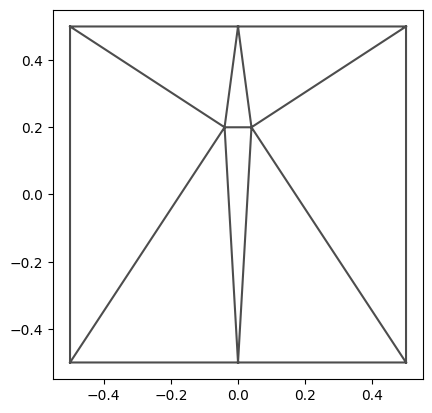

In [3]:
# Draw mesh using matplotlib
import matplotlib.pyplot as plt

plt.triplot(vertices[:, 0], vertices[:, 1], triangles, color=(0.3, 0.3, 0.3))
plt.axis('equal')
plt.axis('square')

As an alternate method for drawing the mesh we can use our `visualizable_simplicial_mesh` included as a module with this tutorial. (This is not part of standard PyDEC distribution).

********************************************************************************
         to build the TVTK classes (9.4). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



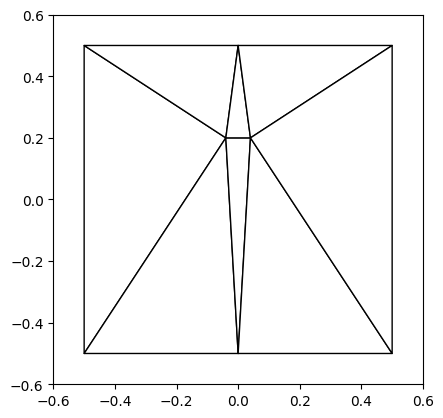

In [4]:
# Draw mesh using visualizable simplicial mesh
from vismesh import visualizable_simplicial_mesh

vm = visualizable_simplicial_mesh((vertices, triangles))
vm.draw()

This has some features helpful in debugging. For example, we can examing the numbering for all the simplices. This is useful for smallish meshes.

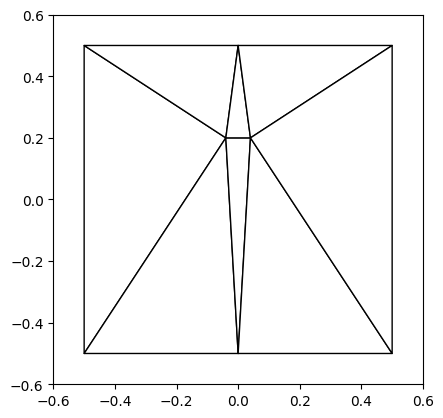

In [5]:
# Display simplex numbers

vm.draw()
vm.display_indices()

There is a system for orienting the top dimensional simplices (triangles here) and lower dimensional simplices (edges). These are specified using the vertex ordering.

Meshes can also be loaded from various types of files. Here is an example if using text files included with this tutorial.

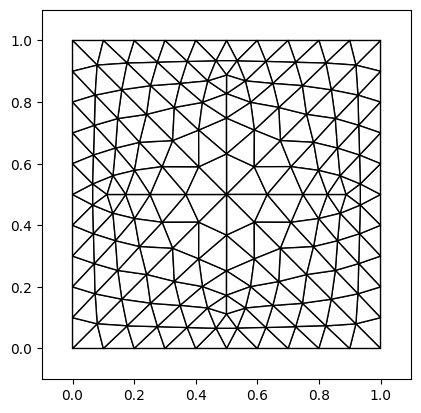

In [6]:
# Load larger mesh of square and draw it using `visualizable_simplicial_mesh`
vertices = np.loadtxt('meshes/square272/vertices.txt')
triangles = np.loadtxt('meshes/square272/triangles.txt', dtype=int)
vm = visualizable_simplicial_mesh((vertices, triangles))
vm.draw()

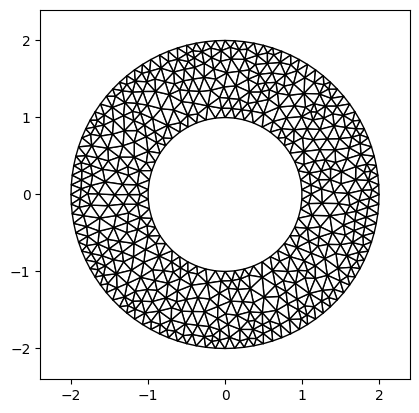

In [7]:
# Load a mesh of an annulus and display it.

vertices = np.loadtxt('meshes/annulus974/vertices.txt')
triangles = np.loadtxt('meshes/annulus974/triangles.txt', dtype=int)
vm = visualizable_simplicial_mesh((vertices, triangles))
vm.draw()

---

## Discrete exterior derivatives

The discrete exterior derivatives are the coboundary operators. There are 3 for a mesh in two dimensions: $d_0$, $d_1$, and $d_2$. Let's print those for the square with 8 triangles which is reproduced below
![Square figure](square8.pdf)

In [8]:
# d0, d1, d2

vertices = np.loadtxt('meshes/square8/vertices.txt')
triangles = np.loadtxt('meshes/square8/triangles.txt', dtype=int)
sc = simplicial_complex((vertices, triangles))
d0 = sc[0].d
d1 = sc[1].d
d2 = sc[2].d

In [9]:
d0.todense()

matrix([[-1,  1,  0,  0,  0,  0,  0,  0],
        [-1,  0,  1,  0,  0,  0,  0,  0],
        [-1,  0,  0,  1,  0,  0,  0,  0],
        [ 0, -1,  1,  0,  0,  0,  0,  0],
        [ 0, -1,  0,  0,  1,  0,  0,  0],
        [ 0,  0, -1,  1,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  1,  0,  0,  0],
        [ 0,  0, -1,  0,  0,  1,  0,  0],
        [ 0,  0,  0, -1,  0,  1,  0,  0],
        [ 0,  0,  0, -1,  0,  0,  1,  0],
        [ 0,  0,  0,  0, -1,  1,  0,  0],
        [ 0,  0,  0,  0, -1,  0,  0,  1],
        [ 0,  0,  0,  0,  0, -1,  1,  0],
        [ 0,  0,  0,  0,  0, -1,  0,  1],
        [ 0,  0,  0,  0,  0,  0, -1,  1]], dtype=int8)

Note the complex property: $d_1 d_0 = 0$ using matrix multiplication

In [10]:
# Complex property

print((d1*d0).todense())

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [11]:
print((d2*d1).todense())

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


## Hodge star

The DEC Hodge star matrices are diagonal matrices with all positive entries. The values are dual over primal measure. There is one matrix for each dimension (0,1,2).

In [12]:
# Hodge star 0, 1, 2 matrices

DEC does not save an explicit representation of the dual cell complex

---

## PDEs with Hodge-Laplacian

Now we will solve two different PDEs with Hodge-Laplace operator. This can be done in mixed form or direct form.

### Hodge-Laplace Poisson problem on $0$-forms 

$\Delta_0 u = f$ on $M$ with $*d u = 0$ on $\partial M$ and $u \perp$ harmonic 0-forms.

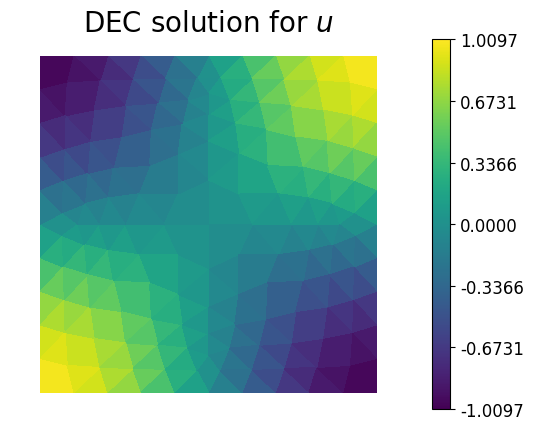

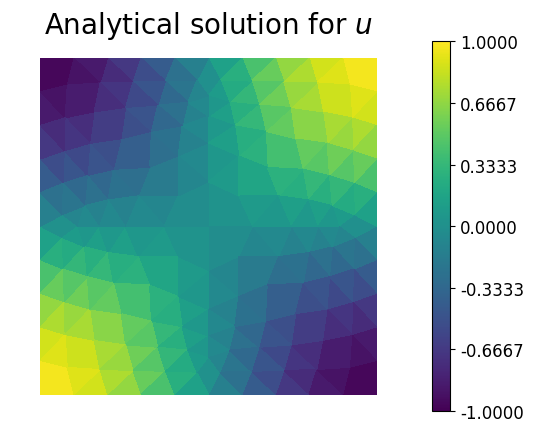

In [13]:
import scipy.sparse as sprs
import scipy.sparse.linalg as spla

# We first need a known solution and the corresponding right hand side function
def u_analytical(x, y):
    return np.cos(np.pi*x) * np.cos(np.pi*y)

def f(x, y):
    return 2 * np.pi**2 * np.cos(np.pi*x) * np.cos(np.pi*y)

# We shall solve this problem on the unit square from above
vertices = np.loadtxt('meshes/square272/vertices.txt')
triangles = np.loadtxt('meshes/square272/triangles.txt', dtype=np.int64)
vm = visualizable_simplicial_mesh(vertices, triangles)

# We now set up the discretized Laplacian and right hand side
N0 = vm[0].num_simplices    # Number of vertices
d0 = vm[0].d    # The d0 matrix
hodge0 = vm[0].star    # Hodge star 0
hodge1 = vm[1].star    # Hodge star 1
A = d0.T * hodge1 * d0    # Stiffness matrix corresponding to the system
b = np.zeros(N0)    # Initial right hand side...
u = np.zeros(N0)    # and solution vectors
b = np.array([f(*v) for v in vm.vertices])    # Compute the discretized right hand side

C = np.asmatrix(np.ones(N0))    # Constraint matrix for u orthogonal to harmonics
K = sprs.bmat([[A, C.T],
               [C, None]], format='csr')
rhs = np.hstack((hodge0 * b, [0]))    # Solve constrainted linear system using Lagrange multipliers
x = spla.spsolve(K, rhs)    # Solution using a sparse direct solvers
u = x[:N0]    # Extract the solution...
lmbda = x[N0]    # and ignore the Lagrange multiplier

# Visualize
u_true = np.array([u_analytical(*v) for v in vm.vertices])
plt.figure(); ax = plt.gca()
plt.tripcolor(vertices[:, 0], vertices[:, 1], triangles, u, vmin=min(u), vmax=max(u))
cb = plt.colorbar(ticks=np.linspace(min(u), max(u), 7), format='%1.4f')
plt.axes(cb.ax);
plt.yticks(fontsize=12); plt.axes(ax)
ax.set_title("DEC solution for $u$", fontsize=20)
plt.axis('equal'); ax.set_axis_off()

plt.figure(); ax = plt.gca()
plt.tripcolor(vertices[:, 0], vertices[:, 1], triangles, u_true, vmin=min(u_true), vmax=max(u_true))
cb = plt.colorbar(ticks=np.linspace(min(u_true), max(u_true), 7), format='%1.4f')
plt.axes(cb.ax);
plt.yticks(fontsize=12); plt.axes(ax)
ax.set_title("Analytical solution for $u$", fontsize=20)
plt.axis('equal'); ax.set_axis_off()

#### Helmholtz problem

Hodge-Laplace Helmholtz problem on $0$-forms: $\Delta_0 u = \lambda u$ on $M$ with $*u = 0$, $* d u = 0$ on $\partial M$.

Computed eigenvalues are:  [-2.39912257e-15  4.60036850e-01  4.60089079e-01  1.79669985e+00
  1.79707573e+00  3.89624420e+00]


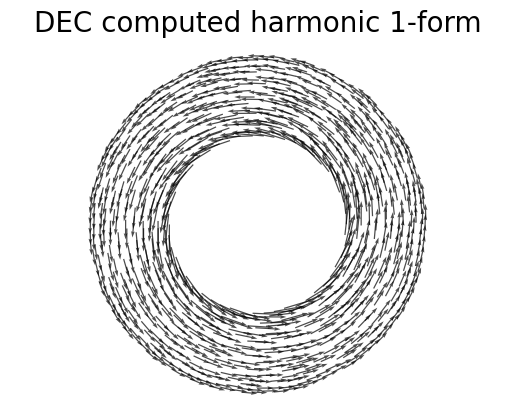

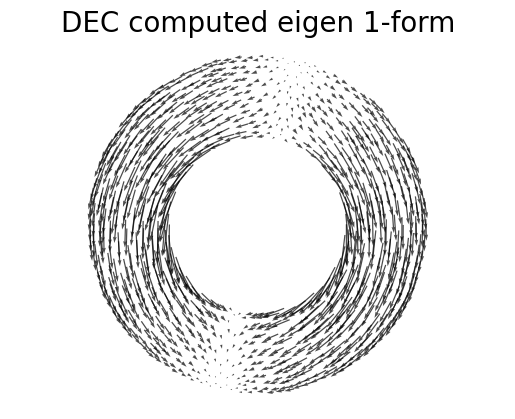

In [14]:
import numpy.linalg as npla
from pydec import simplex_quivers

# We shall solve this problem on the annulus domain as earlier
vertices = np.loadtxt('meshes/annulus974/vertices.txt')
triangles = np.loadtxt('meshes/annulus974/triangles.txt', dtype=int)

# Setup and solve
sc = simplicial_complex(vertices, triangles)
vm = visualizable_simplicial_mesh(vertices, triangles)

# Obtain the discrete exterior derivative matrices
d0 = sc[0].d
d1 = sc[1].d

# The count of the number of vertices and edges
N0 = sc[0].num_simplices
N1 = sc[1].num_simplices

# The DEC Hodge stars
hodge0 = sc[0].star
hodge1 = sc[1].star
hodge2 = sc[2].star

# Setup the matrices for the generalized Hodge Laplacian Helmholtz problem
A = sprs.bmat([[hodge0, -d0.T * hodge1],
               [hodge1 * d0, d1.T * hodge2 * d1]], format='csr')
B = sprs.bmat([[sprs.csr_matrix((N0, N0)), None], 
               [None, hodge1]], format='csr')

# Compute the eigenvalues and eigenvectors using a sparse eigensolver.
# We are trying to obtain the smallest magnitude {eigenvalues, eigenvectors} using shifts
evals, evectors = spla.eigsh(A=A, k=6, M=B, sigma=0.01)
print("Computed eigenvalues are: ", evals)

# (Note: Eigenvectors are stored column wise, e.g., the first eigenvector is in the first column in evectors.)

# Obtain the u component of the eigenvectors
u_evectors = evectors[N0:, :]
# Normalize eigenvectors for "nicer" plots (remember this is still an eigenvector)
for i in range(evectors.shape[1]):
    u_evectors[:, i] /= npla.norm(u_evectors[:, i])

# Visualize the eigenvectors corresponding to the smallest and second smallest magnitude eigenvalues.
# PyDEC in-built function to interpolate a 1-cochain to a Whitney 1-form, and sample it at the simplex barycenters
bases, arrows1 = simplex_quivers(sc, u_evectors[:, 0])

plt.figure(); ax = plt.gca()
custom_quiver = {'color': 'k', 'alpha': 0.7, 'scale': 1, 'scale_units': 'xy', 'width': 0.0025}
ax.quiver(bases[:, 0], bases[:, 1], arrows1[:, 0], arrows1[:, 1],**custom_quiver)
ax.set_title("DEC computed harmonic 1-form", fontsize=20)
plt.axis('equal'); ax.set_axis_off()

# The eigenvector corresponding to the second nonzero eigenvalue
bases, arrows2 = simplex_quivers(sc, u_evectors[:, 1])

plt.figure(); ax = plt.gca()
ax.quiver(bases[:, 0], bases[:, 1], arrows2[:, 0], arrows2[:, 1],**custom_quiver)
ax.set_title("DEC computed eigen 1-form", fontsize=20)
plt.axis('equal'); ax.set_axis_off()


---

## Connection with finite element exterior calculus

By replacing the diagonal DEC mass matrices with lowest order FEEC mass matrices the above setup becomes a finite element method.

In [15]:
# FEEC version of Hodge-Laplace problem

Whitney forms allow one to visualize the solutions computed as a vector field.

In [16]:
# Visualize the FEEC Hodge-Laplace solution for k=1

In [17]:
# Visualize the DEC Hodge-Laplace solution for k=1

---

## Working with graphs

Abstract simplicial complexes in PyDEC allows working with graphs and graph Laplacians.

In [18]:
# Create a simple graph

The graph Laplacian is $d_0^T d_0$

In [19]:
# Print d_0 and the graph Laplacian